Noisy input shape: torch.Size([1, 128])
Clean target shape: torch.Size([1, 128])


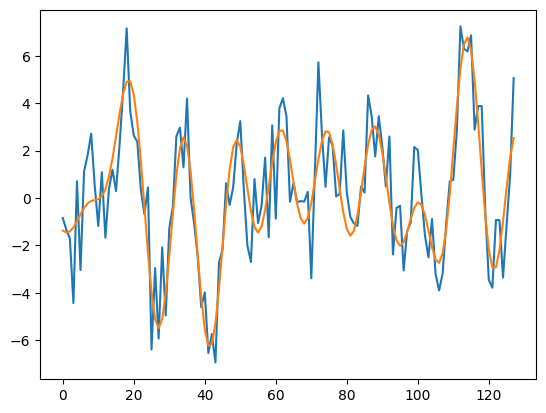

In [57]:
import torch
from torch.utils.data import Dataset, DataLoader
import math
import random


import torch
import torch.nn as nn
import matplotlib.pyplot as plt


class SineDataset(Dataset):
    def __init__(self, 
                 num_samples=1, 
                 signal_length=128, 
                 num_sinusoids=10,
                 freq_range=(1, 10), 
                 amplitude_range=(0.5, 1.5),
                 noise_std=1.5,
                 device='cpu'):
        """
        Generate random sum-of-sinusoids data with noise.
        """
        super().__init__()
        self.num_samples = num_samples
        self.signal_length = signal_length
        self.num_sinusoids = num_sinusoids
        self.freq_range = freq_range
        self.amplitude_range = amplitude_range
        self.noise_std = noise_std
        self.device = device
        
        # Pre-generate all samples (for a simple dataset)
        self.data, self.targets = self._generate_data()
    
    def _generate_data(self):
        data_list = []
        target_list = []
        
        t = torch.linspace(0, 2 * math.pi, steps=self.signal_length)
        
        for _ in range(self.num_samples):
            # Generate sum of random sinusoids
            clean_signal = torch.zeros(self.signal_length)
            for __ in range(self.num_sinusoids):
                freq = random.uniform(*self.freq_range)
                amp = random.uniform(*self.amplitude_range)
                phase = random.uniform(0, 2 * math.pi)
                clean_signal += amp * torch.sin(freq * t + phase)
            
            # Add noise
            noise = torch.randn(self.signal_length) * self.noise_std
            noisy_signal = clean_signal + noise
            
            data_list.append(noisy_signal.unsqueeze(0))   # shape: [1, L]
            target_list.append(clean_signal.unsqueeze(0)) # shape: [1, L]
        
        data = torch.stack(data_list, dim=0).to(self.device)   # [N, 1, L]
        targets = torch.stack(target_list, dim=0).to(self.device) # [N, 1, L]
        return data, targets
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]


dataset = SineDataset(num_samples=10)
x, y = dataset[0]
print("Noisy input shape:", x.shape)    # [1, L]
print("Clean target shape:", y.shape)   # [1, L]
plt.plot(x[0])
plt.plot(y[0])
plt.show()


In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # x: shape [B, channels, length]
        identity = x
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out = out + identity
        out = self.relu(out)
        return out

class Adapter(nn.Module):
    """
    Adapter to transform intermediate feature map into [B, 1, L] dimension
    for computing loss/visualizing partial outputs.
    """
    def __init__(self, in_channels, out_length):
        super().__init__()
        # 1) Collapse channels into a single channel
        self.conv = nn.Conv1d(in_channels, 1, kernel_size=1)
        # 2) We might need to upsample or downsample the spatial dimension
        self.out_length = out_length
    
    def forward(self, x):
        # x in shape [B, C, L_intermediate]
        x = self.conv(x)  # -> [B, 1, L_intermediate]
        if x.shape[-1] != self.out_length:
            x = F.interpolate(x, size=self.out_length, mode='nearest')
        return x

class EarlyExitResnetAutoencoder(nn.Module):
    def __init__(self, 
                 input_length=128, 
                 base_channels=16, 
                 num_blocks=3):
        """
        A toy ResNet autoencoder with multiple residual blocks and 
        an 'early exit' after each block.
        """
        super().__init__()
        
        self.input_length = input_length
        self.base_channels = base_channels
        self.num_blocks = num_blocks
        
        # == Encoder initial ==
        self.conv_in = nn.Conv1d(1, base_channels, kernel_size=3, padding=1)
        
        # == Residual blocks (encoder) ==
        self.encoder_blocks = nn.ModuleList([
            ResidualBlock(base_channels) for _ in range(num_blocks)
        ])
        
        # Optionally do some downsampling here in each block if you like,
        # but we'll keep it simple with no stride/pool for demonstration.
        
        # == Bottleneck layer ==
        # For simplicity, let's keep everything at the same resolution
        # in this toy example. In a real model, we might shrink and then expand.
        self.bottleneck = ResidualBlock(base_channels)
        
        # == Decoder blocks ==
        self.decoder_blocks = nn.ModuleList([
            ResidualBlock(base_channels) for _ in range(num_blocks)
        ])
        
        # == Final output ==
        self.conv_out = nn.Conv1d(base_channels, 1, kernel_size=3, padding=1)
        
        # == Adapters for each stage (to produce partial reconstructions) ==
        # We'll have a partial exit after each encoder block and after each 
        # decoder block, plus the final output. That’s 2*num_blocks + 1 in total 
        # if you want to see them all. For simplicity, let's do just 
        # after each *encoder block* plus the final.
        self.adapters = nn.ModuleList([
            Adapter(base_channels, input_length) for _ in range(num_blocks)
        ])
        # We can also have an adapter for the final output if we want 
        # a consistent interface (but conv_out already produces shape [1,L]). 
        # Here I'll just keep the final as is.
        
    def forward(self, x):
        """
        Return a list of outputs (partial reconstructions) for each exit
        plus the final output.
        """
        # x: shape [B, 1, L]
        # 1) Initial conv
        x_enc = self.conv_in(x)  # [B, base_channels, L]
        
        # 2) Pass through encoder blocks, collect partial exits
        partial_outputs = []
        current = x_enc
        for i, block in enumerate(self.encoder_blocks):
            current = block(current)
            # Create partial exit from this stage
            partial_outputs.append(self.adapters[i](current))
        
        # 3) Bottleneck
        bottleneck_out = self.bottleneck(current)
        
        # 4) Decoder blocks (for toy example, we do symmetrical shape)
        current = bottleneck_out
        for block in self.decoder_blocks:
            current = block(current)
        
        # 5) Final output
        final = self.conv_out(current)  # shape [B, 1, L]
        
        # Return the partial exits plus the final output
        # (You could also add partial outputs from the decoder stage if desired.)
        return partial_outputs, final


In [59]:
import torch.optim as optim

def train_model(model, 
                dataloader, 
                num_epochs=5, 
                lr=1e-3, 
                device='cpu'):
    
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    mse_loss = nn.MSELoss()
    
    # Define weights for each exit (must match the number of partial outputs + final output)
    exit_weights_unnorm = [1, 2, 4]
    exit_weights_unnorm = [4, 2, 1]
    exit_weights = [x / sum(exit_weights_unnorm) for x in exit_weights_unnorm]

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        
        for batch_idx, (noisy, clean) in enumerate(dataloader):
            noisy = noisy.to(device)   # [B, 1, L]
            clean = clean.to(device)   # [B, 1, L]
            
            optimizer.zero_grad()
            
            partial_outputs, final_output = model(noisy)
            
            # Compute MSE at each exit and apply weights
            losses = []
            for weight, p_out in zip(exit_weights[:-1], partial_outputs):
                losses.append(weight * mse_loss(p_out, clean))
            
            # Add the final output loss with its weight
            losses.append(exit_weights[-1] * mse_loss(final_output, clean))
            
            # Combine the weighted losses
            total_mse = sum(losses)
            total_mse.backward()
            
            optimizer.step()
            
            total_loss += total_mse.item() * noisy.size(0)
        
        epoch_loss = total_loss / len(dataloader.dataset)
        print(f"[Epoch {epoch+1}] Loss: {epoch_loss:.6f}")




In [60]:
if __name__ == "__main__":
    # 1) Create the dataset and dataloader
    dataset = SineDataset(
        num_samples=1000, 
        signal_length=1024,
        num_sinusoids=3,
        noise_std=0.1,
        device='cuda'
    )
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    # 2) Create the model
    model = EarlyExitResnetAutoencoder(
        input_length=1024, 
        base_channels=16, 
        num_blocks=3
    )
    
    # 3) Train
    train_model(model, dataloader, num_epochs=500, lr=1e-3, device='cuda')
    
    # 4) Inference / early exit
    # Let's say we do inference on a single sample and see partial outputs.
    model.eval()
    test_noisy, test_clean = dataset[0]  # single sample
    test_noisy = test_noisy.unsqueeze(0) # [1, 1, L]
    
    with torch.no_grad():
        partial_outputs, final_output = model(test_noisy)
    
    print("Number of early-exit partial outputs:", len(partial_outputs))
    for i, p_out in enumerate(partial_outputs):
        print(f"Partial exit {i} shape: {p_out.shape}")
    print("Final output shape:", final_output.shape)
    
    # Suppose at inference time we want to 'exit early' after the first partial output
    early_exit_output = partial_outputs[0]
    print("Early exit output shape:", early_exit_output.shape)


[Epoch 1] Loss: 1.522654
[Epoch 2] Loss: 0.268190
[Epoch 3] Loss: 0.020016
[Epoch 4] Loss: 0.008143
[Epoch 5] Loss: 0.004559
[Epoch 6] Loss: 0.003674
[Epoch 7] Loss: 0.003403
[Epoch 8] Loss: 0.003280
[Epoch 9] Loss: 0.003151
[Epoch 10] Loss: 0.003224
[Epoch 11] Loss: 0.002999
[Epoch 12] Loss: 0.002920
[Epoch 13] Loss: 0.002848
[Epoch 14] Loss: 0.002948
[Epoch 15] Loss: 0.002681
[Epoch 16] Loss: 0.002617
[Epoch 17] Loss: 0.002562
[Epoch 18] Loss: 0.002523
[Epoch 19] Loss: 0.002501
[Epoch 20] Loss: 0.002470
[Epoch 21] Loss: 0.002479
[Epoch 22] Loss: 0.002399
[Epoch 23] Loss: 0.002334
[Epoch 24] Loss: 0.002293
[Epoch 25] Loss: 0.002251
[Epoch 26] Loss: 0.002328
[Epoch 27] Loss: 0.002237
[Epoch 28] Loss: 0.002165
[Epoch 29] Loss: 0.002147
[Epoch 30] Loss: 0.002116
[Epoch 31] Loss: 0.002174
[Epoch 32] Loss: 0.002060
[Epoch 33] Loss: 0.002049
[Epoch 34] Loss: 0.002028
[Epoch 35] Loss: 0.002011
[Epoch 36] Loss: 0.001995
[Epoch 37] Loss: 0.001984
[Epoch 38] Loss: 0.001920
[Epoch 39] Loss: 0.00

Using device: cuda


Trained model loaded.
Average MSE for Exit 1: 0.006061
Average MSE for Exit 2: 0.003947
Average MSE for Exit 3: 1.792155
Average MSE for Final Output: 0.002966


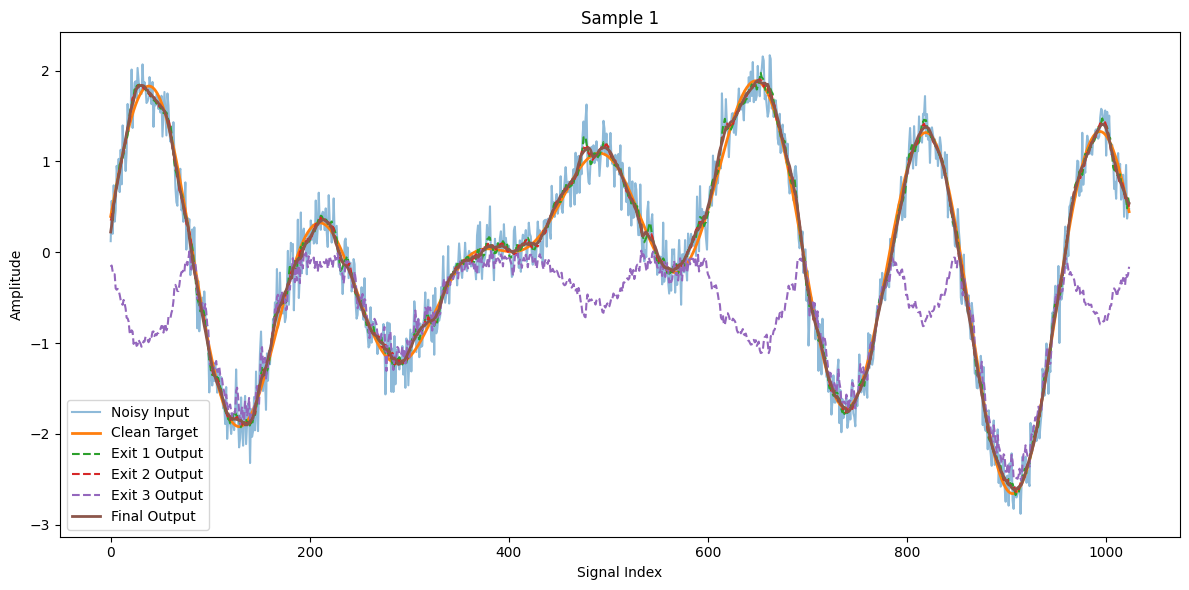

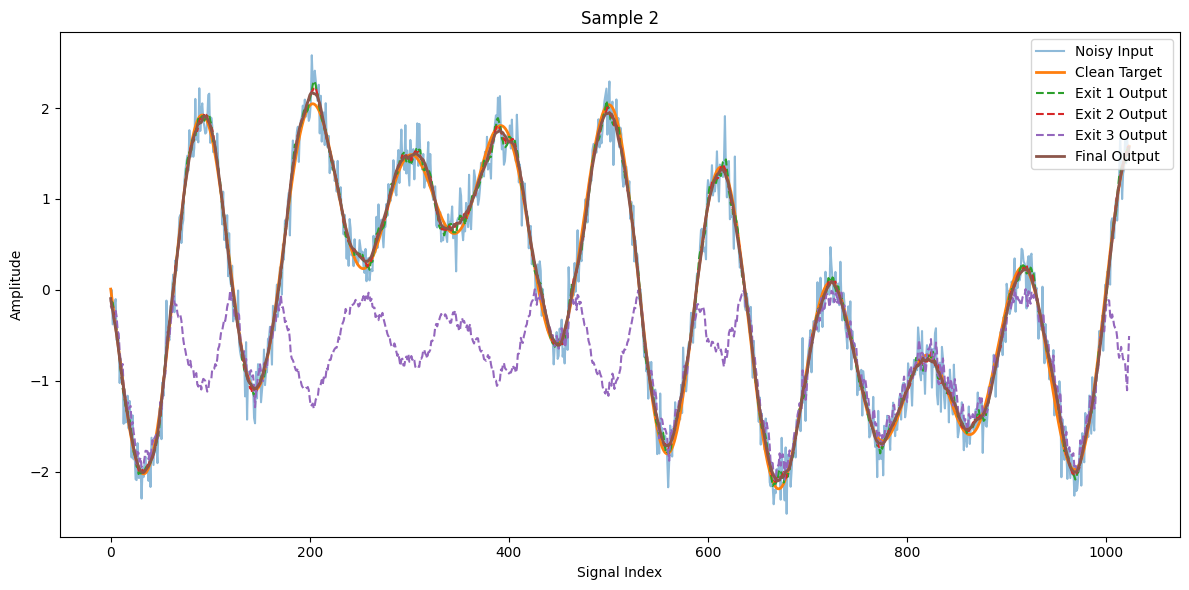

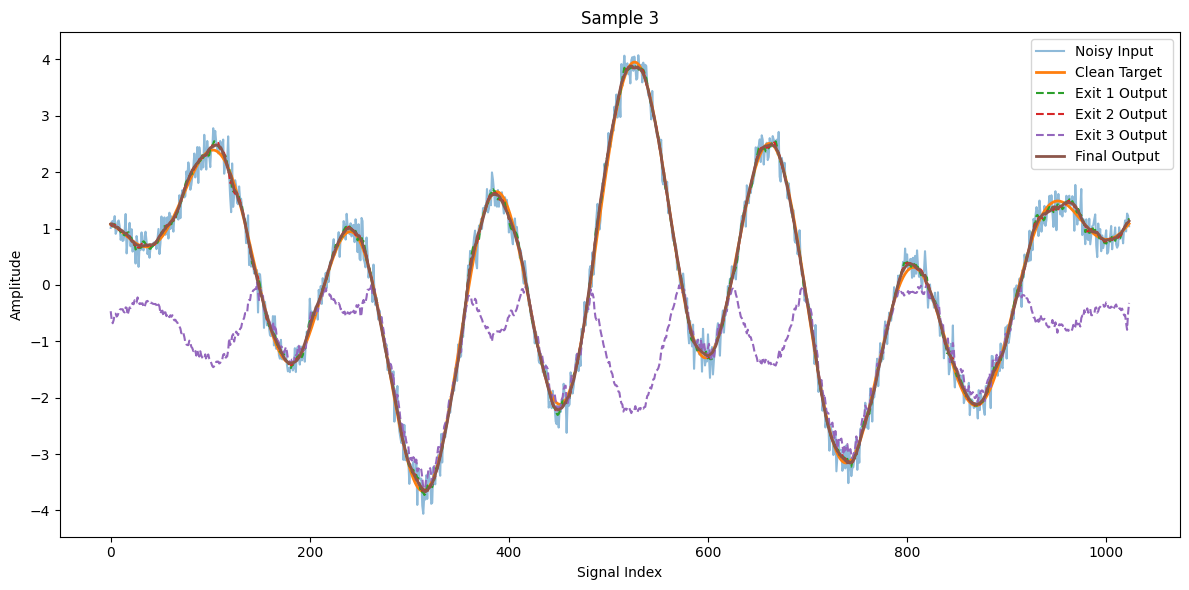

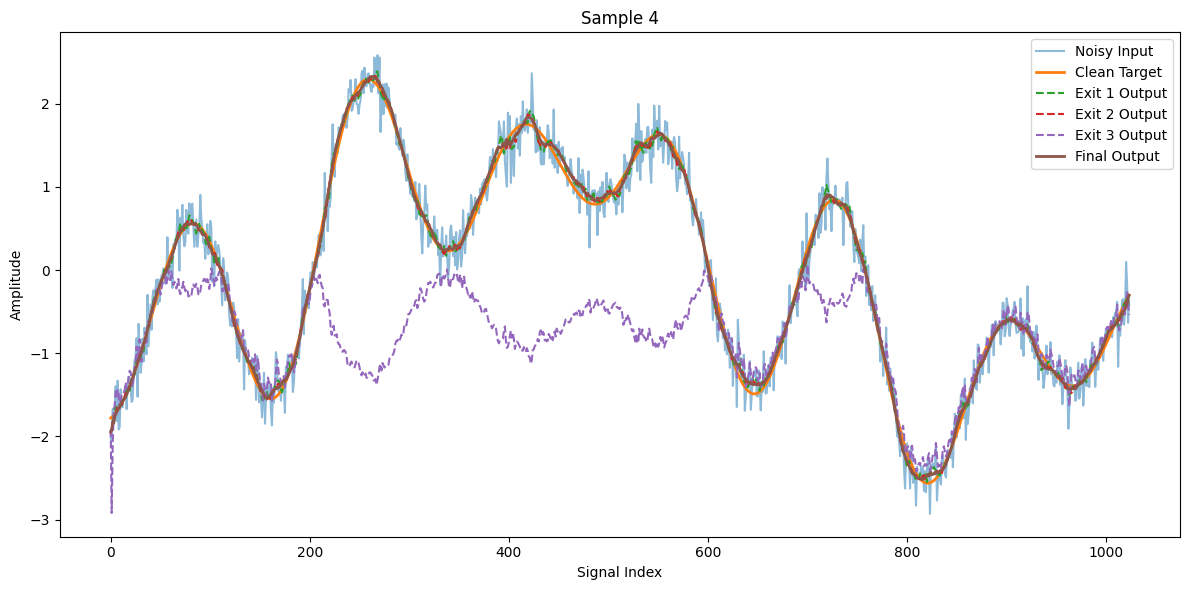

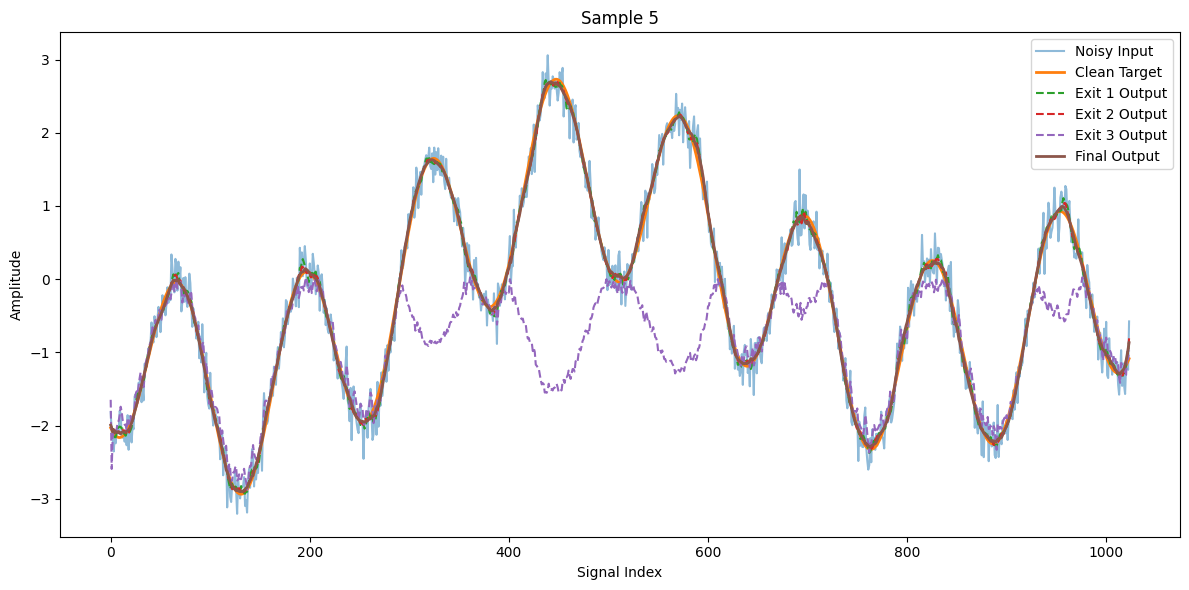

In [61]:
import torch
from torch.utils.data import DataLoader

# Define parameters
TEST_NUM_SAMPLES = 200  # Number of test samples
SIGNAL_LENGTH = 128     # Must match the training signal length
NUM_SINUSOIDS = 3       # Must match the training configuration
NOISE_STD = 0.1         # Must match the training noise level
BATCH_SIZE = 32         # Adjust as needed

# Create the test dataset
test_dataset = SineDataset(
    num_samples=TEST_NUM_SAMPLES,
    signal_length=SIGNAL_LENGTH,
    num_sinusoids=NUM_SINUSOIDS,
    noise_std=NOISE_STD,
    device='cpu'  # Use 'cuda' if GPU is available and desired
)

# Create the test DataLoader
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False  # No need to shuffle for testing
)



def test_model(model, dataloader, device='cpu'):
    """
    Evaluate the model on the test dataset.

    Args:
        model (nn.Module): Trained model with early exits.
        dataloader (DataLoader): DataLoader for the test dataset.
        device (str): Device to perform computations on.

    Returns:
        dict: A dictionary containing average MSE for each exit and the final output.
    """
    model.to(device)
    model.eval()
    mse_loss = nn.MSELoss()
    
    # Initialize accumulators for losses
    exit_losses = None  # Will be a list once known
    final_loss_total = 0.0
    num_samples = 0
    
    # For visualization: store first few samples
    visualize_samples = []
    max_visualize = 5  # Number of samples to store for plotting

    with torch.no_grad():
        for batch_idx, (noisy, clean) in enumerate(dataloader):
            noisy = noisy.to(device)  # [B, 1, L]
            clean = clean.to(device)  # [B, 1, L]
            batch_size = noisy.size(0)
            
            partial_outputs, final_output = model(noisy)
            
            # Initialize exit_losses on first batch
            if exit_losses is None:
                num_exits = len(partial_outputs) + 1  # +1 for final output
                exit_losses = [0.0 for _ in range(num_exits)]
            
            # Compute MSE for each partial output
            for i, p_out in enumerate(partial_outputs):
                loss = mse_loss(p_out, clean)
                exit_losses[i] += loss.item() * batch_size  # Sum over batch

            # Compute MSE for final output
            final_loss = mse_loss(final_output, clean)
            exit_losses[-1] += final_loss.item() * batch_size
            
            # Accumulate total samples
            num_samples += batch_size
            
            # Store samples for visualization
            if len(visualize_samples) < max_visualize:
                for i in range(batch_size):
                    if len(visualize_samples) >= max_visualize:
                        break
                    visualize_samples.append({
                        'noisy': noisy[i].cpu().squeeze().numpy(),
                        'clean': clean[i].cpu().squeeze().numpy(),
                        'partial_outputs': [p_out[i].cpu().squeeze().numpy() for p_out in partial_outputs],
                        'final_output': final_output[i].cpu().squeeze().numpy()
                    })
    
    # Compute average MSE for each exit
    average_exit_losses = [loss / num_samples for loss in exit_losses]
    
    # Display the average losses
    for i, loss in enumerate(average_exit_losses[:-1]):
        print(f"Average MSE for Exit {i+1}: {loss:.6f}")
    print(f"Average MSE for Final Output: {average_exit_losses[-1]:.6f}")
    
    # Plot some example outputs
    plot_samples(visualize_samples, num_exits=num_exits-1)
    
    return average_exit_losses

def plot_samples(samples, num_exits):
    """
    Plot example denoised signals from the model.

    Args:
        samples (list): List of dictionaries containing 'noisy', 'clean', 'partial_outputs', 'final_output'.
        num_exits (int): Number of early exits.
    """
    for idx, sample in enumerate(samples):
        plt.figure(figsize=(12, 6))
        plt.title(f"Sample {idx+1}")
        
        # Plot noisy input
        plt.plot(sample['noisy'], label='Noisy Input', alpha=0.5)
        
        # Plot clean target
        plt.plot(sample['clean'], label='Clean Target', linewidth=2)
        
        # Plot partial exits
        for i, p_out in enumerate(sample['partial_outputs']):
            plt.plot(p_out, label=f'Exit {i+1} Output', linestyle='--')
        
        # Plot final output
        plt.plot(sample['final_output'], label='Final Output', linestyle='-', linewidth=2)
        
        plt.legend()
        plt.xlabel('Signal Index')
        plt.ylabel('Amplitude')
        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    # Device configuration
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    
    # 1) Create the test dataset and dataloader (as defined earlier)
    test_dataset = SineDataset(
        num_samples=200, 
        signal_length=1024,
        num_sinusoids=3,
        noise_std=0.2,
        device='cpu'  # Ensure consistency; can set to 'cuda' if desired
    )
    test_dataloader = DataLoader(
        test_dataset, 
        batch_size=32, 
        shuffle=False
    )
    

    print("Trained model loaded.")
    
    # 3) Run the test
    average_exit_losses = test_model(model, test_dataloader, device=device)


In [66]:
import monai
model_dynunet = monai.networks.nets.DynUNet(1, 2, 2, [3, 3, 3, 3, 1], [1, 2, 2, 2, 2], upsample_kernel_size =[1, 2, 2, 2, 2], norm_name='instance', deep_supervision=True, deep_supr_num=3, res_block=True)

In [67]:
model_dynunet

DynUNet(
  (input_block): UnetResBlock(
    (conv1): Convolution(
      (conv): Conv1d(2, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    )
    (conv2): Convolution(
      (conv): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    )
    (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
    (norm1): InstanceNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (norm2): InstanceNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (conv3): Convolution(
      (conv): Conv1d(2, 32, kernel_size=(1,), stride=(1,), bias=False)
    )
    (norm3): InstanceNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (downsamples): ModuleList(
    (0): UnetResBlock(
      (conv1): Convolution(
        (conv): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
      )
      (conv2): Convolution(
        (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,), 